# Implementación de Red Neuronal para Predecir Rendimiento Académico en Estudiantes
## Introducción
Este notebook implementa una red neuronal según el roadmap establecido, usando datos del Instituto Politécnico de Portalegre (IPP) en Portugal. El objetivo es predecir el rendimiento académico de los estudiantes al inicio de sus estudios, utilizando únicamente información disponible al momento de su matrícula.

El dataset ha sido previamente preprocesado, balanceado y está listo para su uso directo.

## Librerías Necesarias y Lectura del Dataset
Cargamos las librerías necesarias y el archivo CSV ya preparado (data_resampled.csv).

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Cargar los datos
df = pd.read_csv('data_resampled.csv')

# Verificar las dimensiones del dataset
print('Forma del dataset:', df.shape)

# Visualizar primeras filas del dataset
df.head()


Forma del dataset: (6700, 94)


,Application order,Daytime/evening attendance,Previous qualification (grade),Admission grade,Displaced,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,...,Mother's qualification: Basic education 3rd cycle,Mother's qualification: Basic education 1st cycle,Mother's qualification: Basic Education 2nd Cycle,Father's qualification: Others,Father's qualification: Secondary education,Father's qualification: Higher education,Father's qualification: Basic education 3rd cycle,Father's qualification: Basic education 1st cycle,Father's qualification: Basic Education 2nd Cycle,Target
0,5,1,122.0,127.3,1,0,1,1,0,20,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1,160.0,142.5,1,0,0,1,0,19,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
2,5,1,122.0,124.8,1,0,0,1,0,19,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,2,1,122.0,119.6,1,0,1,0,0,20,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,1,0,100.0,141.5,0,0,1,0,0,45,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2


## Separación de Inputs (X) y Target (Y)
Separamos las variables independientes (X) del objetivo (Y). Aplicamos codificación one-hot al target porque es una clasificación multiclase.

In [3]:
# Variables independientes (X) y variable dependiente (Y)
X = df.drop(columns=['Target']).values
Y = df['Target'].values.reshape(-1, 1)

# Codificación one-hot del target
encoder = OneHotEncoder(sparse_output=False)
Y_encoded = encoder.fit_transform(Y)

# Mostrar la forma de los arrays
print('Forma X:', X.shape)
print('Forma Y (codificado):', Y_encoded.shape)


Forma X: (6700, 93)
Forma Y (codificado): (6700, 3)


## División de los Datos en Conjunto de Entrenamiento y Prueba
Dividimos el dataset en dos partes: entrenamiento (80%) y prueba (20%), manteniendo la proporción de clases (stratify).

In [4]:
# División del dataset en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_encoded,
    test_size=0.2,
    stratify=Y,
    random_state=42
)

# Verificar dimensiones
print('Conjunto de entrenamiento:', X_train.shape, Y_train.shape)
print('Conjunto de prueba:', X_test.shape, Y_test.shape)


Conjunto de entrenamiento: (5360, 93) (5360, 3)
Conjunto de prueba: (1340, 93) (1340, 3)


## Definición y Construcción del Modelo de Red Neuronal
Creamos una red neuronal según la arquitectura especificada en el roadmap:

* Tres capas ocultas de 128 neuronas (ReLU).

* Inicialización: He normal.

* Capa de salida: 3 neuronas (una por clase) con softmax.

In [5]:
# Construcción del modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],), kernel_initializer='he_normal'),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(3, activation='softmax')
])

# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen del modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,443 (177.51 KB)

 Trainable params: 45,443 (177.51 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del Modelo
Entrenamos la red neuronal durante 50 épocas, usando un batch size de 32, validando con el conjunto de prueba para evaluar su desempeño durante el proceso.

In [6]:

# Entrenamiento del modelo
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test)
)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4820 - loss: 4.0542 - val_accuracy: 0.6813 - val_loss: 0.7292
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6369 - loss: 0.8926 - val_accuracy: 0.6993 - val_loss: 0.6865
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6814 - loss: 0.7970 - val_accuracy: 0.7284 - val_loss: 0.6454
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6969 - loss: 0.7321 - val_accuracy: 0.7007 - val_loss: 0.7913
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6967 - loss: 0.7426 - val_accuracy: 0.7425 - val_loss: 0.6343
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7263 - loss: 0.6697 - val_accuracy: 0.7560 - val_loss: 0.5944
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7225 - loss: 0.7000 - val_accuracy: 0.6224 - val_loss: 0.8702
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7290 - loss: 0.6553 - val_accuracy: 0.

## Evaluación y Visualización de Resultados
Visualizamos gráficamente la evolución de la pérdida (loss) y precisión (accuracy) durante el entrenamiento para verificar posibles problemas como overfitting.

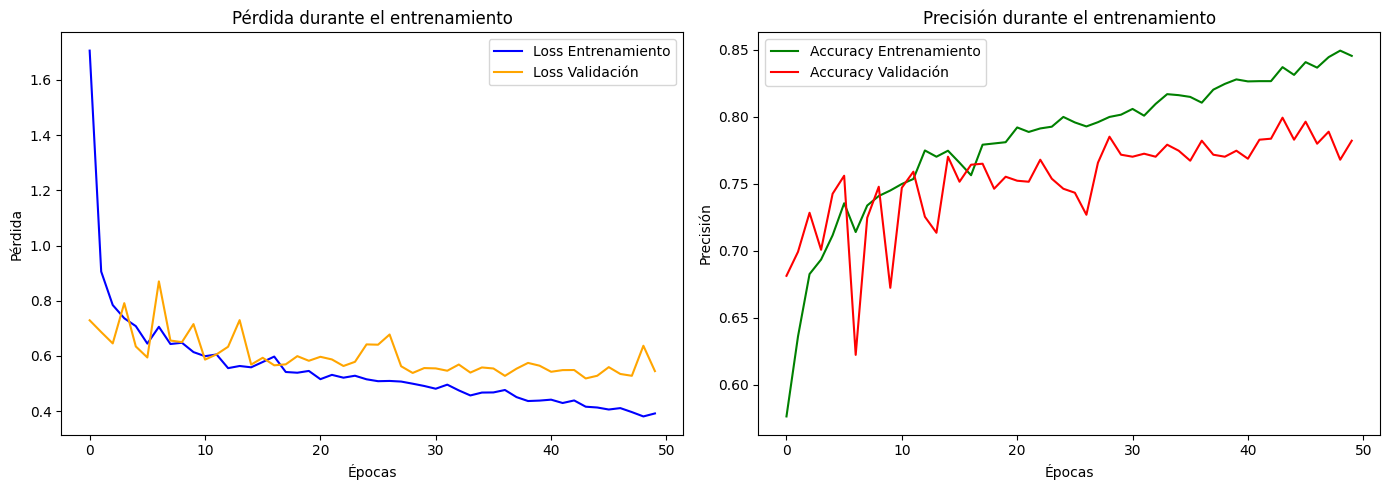

In [7]:
# Visualización de la pérdida y precisión
plt.figure(figsize=(14, 5))

# Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Loss Validación', color='orange')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Accuracy Validación', color='red')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


## Conclusiones y siguientes pasos
Al finalizar el entrenamiento, revisamos gráficamente si el modelo ha aprendido correctamente o si requiere ajustes adicionales como:

* Uso de técnicas contra sobreajuste (dropout, early stopping).

* Ajuste del learning rate o diferentes inicializaciones.

* Reducción o incremento de la arquitectura según resultados observados.